In [1]:
%cd ..

/hdd/aouadt/these/projets/3d_segm


In [2]:
from importlib import reload
import random
from functools import reduce
from os.path import join

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data.dataloader import DataLoader
import pytorch_lightning as pl
import skimage.morphology as morp
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import TensorBoardLogger



import general.array_morphology as arm
import deep_morpho.models.pconv as pconv
import deep_morpho.models.lightning_pconv as lpconv
import deep_morpho.models.dilation_layer as dill
import deep_morpho.models.lightning_dilation_layer as ldill
import deep_morpho.datasets.generate_forms as gfo
import deep_morpho.datasets.multi_rect_dataset as mrda
import deep_morpho.observables.plot_parameters as obs_weights
import deep_morpho.observables as obs

def reload_modules():
    for modl in [arm, pconv, lpconv, dill, ldill, gfo, mrda, obs_weights, obs]:
        reload(modl)
        
reload_modules()

device = 'cpu'
if torch.cuda.is_available():
    device = 'cuda'
print(device)

cuda


In [3]:
def plot_horizontal(imgs, title=None):
    n_figs = len(imgs)
    fig = plt.figure(figsize=(5*n_figs, 5))
    for idx in range(1, n_figs + 1):
        ax = fig.add_subplot(1, n_figs, idx)
        ax.imshow(imgs[idx-1])
        if title is not None:
            ax.set_title(title[idx-1])


# Dataset

Done.


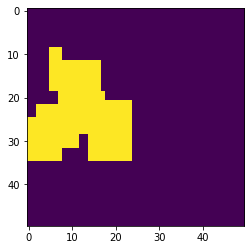

In [339]:
reload_modules()
x, rect_args = gfo.random_multi_rect(
    size=(50, 50), 
    n_rectangles=8,
    max_shape=(10, 10),
    return_rects=True, 
    first_rect_args={
        "top_left_x_props": (.3, .7),
        "top_left_y_props": (.3, .7)
    }
)
plt.imshow(x)


torch.Size([4, 1, 50, 50]) torch.Size([4, 50, 50])
CPU times: user 256 ms, sys: 798 µs, total: 257 ms
Wall time: 120 ms


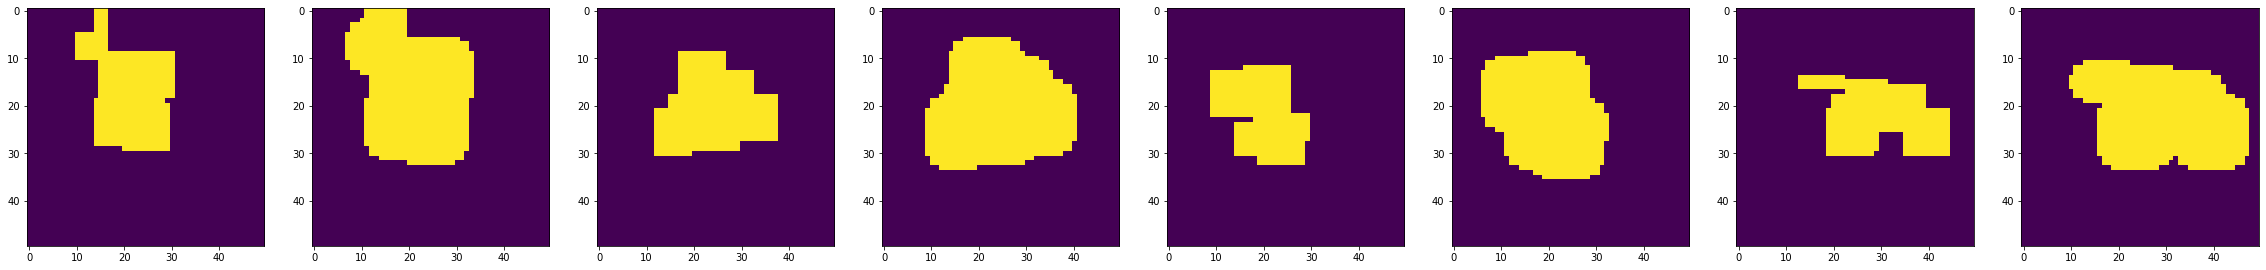

In [511]:
%%time
reload_modules()
dataset = mrda.MultiRectDataset(size=(50, 50), n_rectangles=8, max_shape=(10, 10), selem=morp.disk(3))
# input_, target = dataset[0]
dataloader = DataLoader(dataset, batch_size=4)

inputs, targets = next(iter(dataloader))
print(inputs.shape, targets.shape)

plot_horizontal(
    reduce(lambda a,b: a+b, 
           [[inpt[0].cpu(), target.cpu()] for (inpt, target) in zip(inputs, targets)]))

# Net

In [340]:
reload_modules()
mpc = dill.DilationLayer(in_channels=1, out_channels=1, kernel_size=(5, 5))


Done.


In [349]:
%%time
otp = mpc(torch.tensor(x[np.newaxis, ...]).float().unsqueeze(0))
target = arm.array_dilation(x, morp.disk(3))

CPU times: user 4.86 ms, sys: 0 ns, total: 4.86 ms
Wall time: 2.81 ms


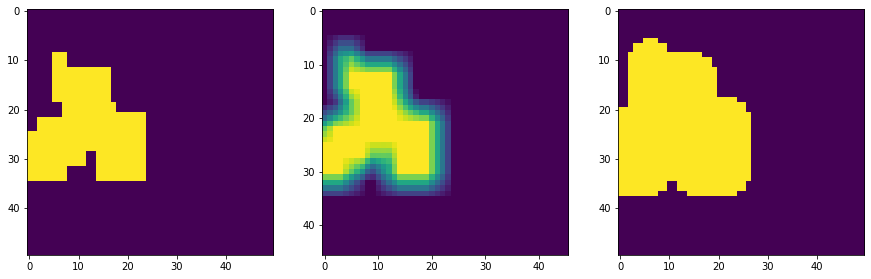

In [372]:
plot_horizontal([
    x,
    otp.detach()[0, 0],
    target
]);




# Training

## Dilation

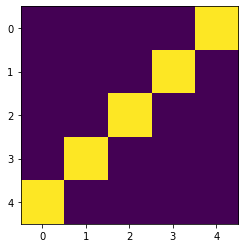

In [4]:
selem = np.zeros((5, 5))
selem[np.arange(5), 5 - np.arange(1, 6)] = 1
plt.imshow(selem)

dataloader = mrda.get_loader(
    batch_size=32, 
    n_inputs=3_000_000, 
    size=(50, 50), 
    n_rectangles=8,
    device=device, 
    max_shape=(10, 10), 
    selem=selem
)

In [107]:
reload_modules()
loss = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam

model = ldill.LightningDilationLayer(
    model_args={
        "in_channels": 1, "out_channels": 1, "kernel_size": (5, 5)
    },
    learning_rate=1e-4,
    loss=loss,
    optimizer=optimizer,
    output_dir="deep_morpho/results"
)
model.to(device)

logger = TensorBoardLogger("deep_morpho/results", name='Dilation')
print(logger.log_dir)

logger.experiment.add_graph(model, torch.ones(1, 1, 50, 50).to(device))

trainer = Trainer(
    max_epochs=1,
    gpus=1 if torch.cuda.is_available() else 0,
    logger=logger,
    progress_bar_refresh_rate=10,
    callbacks=[obs.PlotParameters()]
)

trainer.fit(model, dataloader)


Missing logger folder: deep_morpho/results/Dilation


deep_morpho/results/Dilation/version_0


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
/hdd/python_venvs/torchenv/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: you defined a validation_step but have no val_dataloader. Skipping val loop
  warnings.warn(*args, **kwargs)
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params
--------------------------------------------
0 | model | DilationLayer     | 26    
1 | loss  | BCEWithLogitsLoss | 0     
--------------------------------------------
26        Trainable params
0         Non-trainable params
26        Total params
0.000     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/hdd/python_venvs/torchenv/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 24 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Training: 0it [00:00, ?it/s]

- Unet Version 15: training on $3 \cdot 10^8$ images with softmax before weight
- Dilation Version 0: training on $3 \cdot 10^8$ images without softmax, max min norm

In [103]:
model = model.load_from_checkpoint(join("deep_morpho/results/Unet/version_15/checkpoints/epoch=0-step=93749.ckpt"))

<ipython-input-3-2732c24916c7>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(5*n_figs, 5))


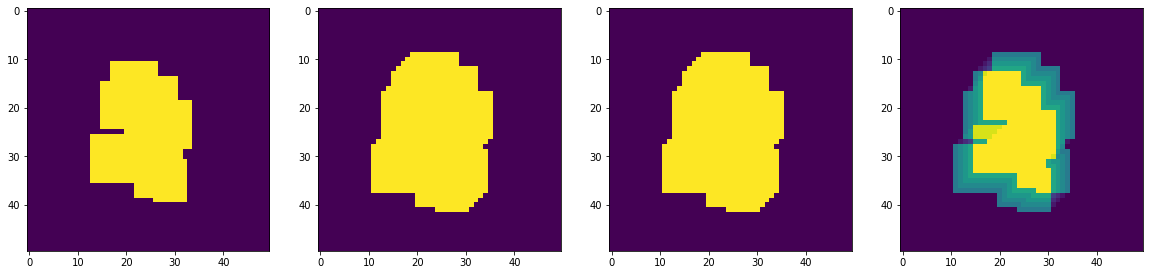

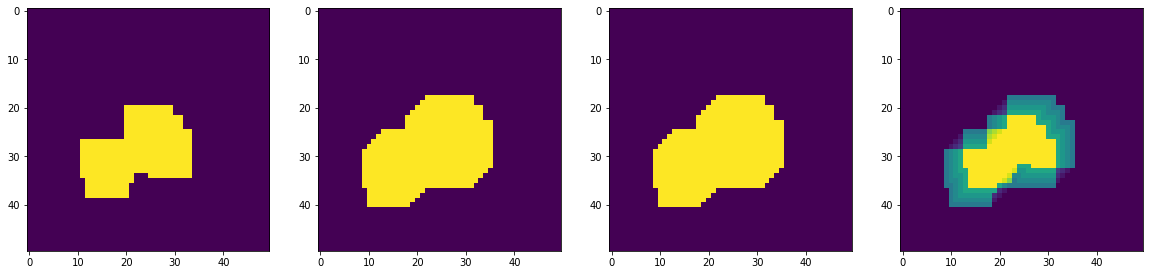

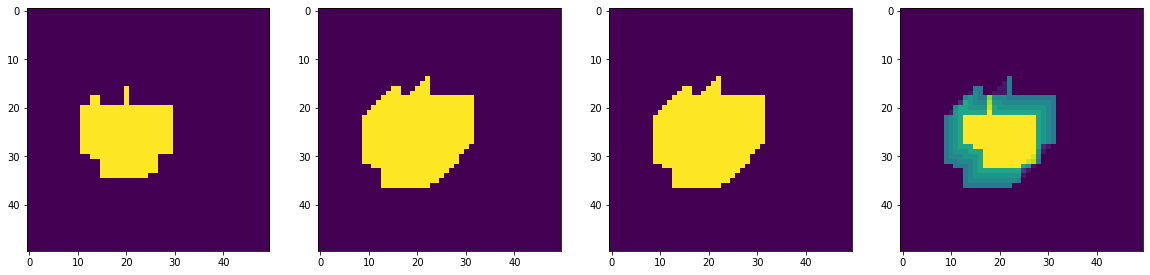

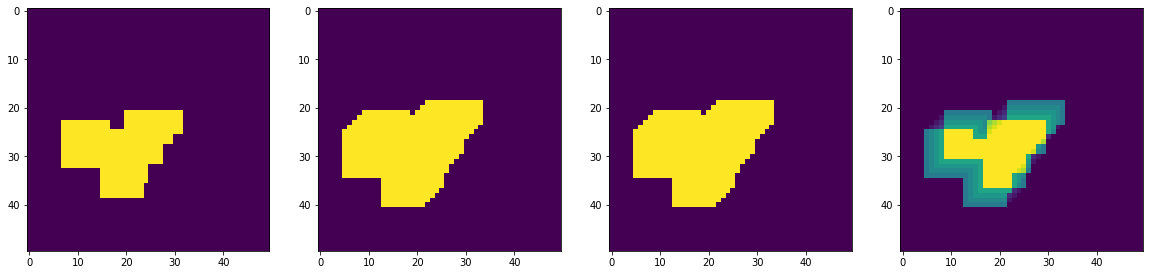

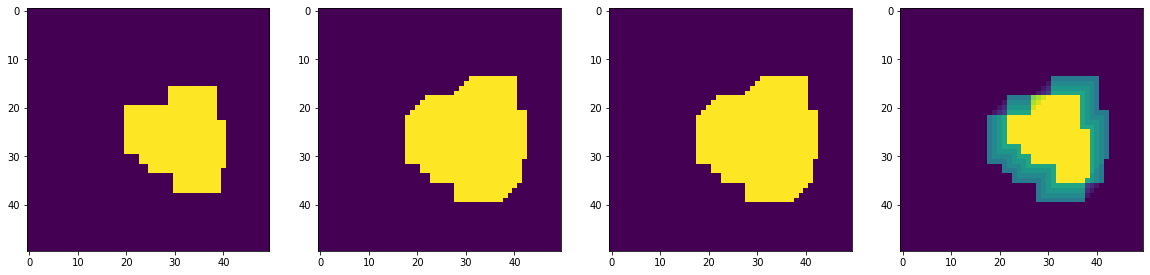

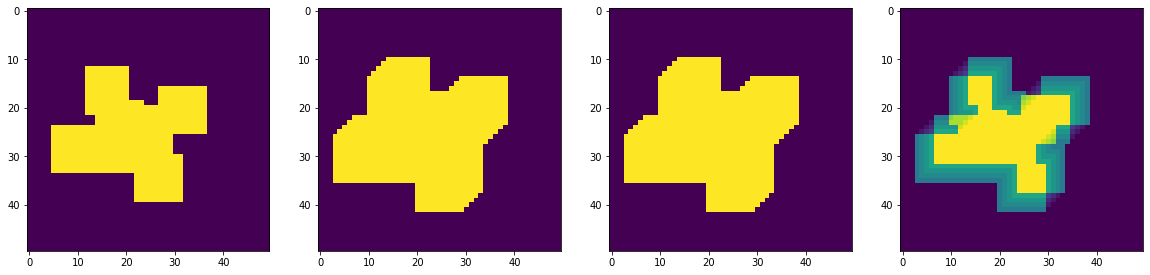

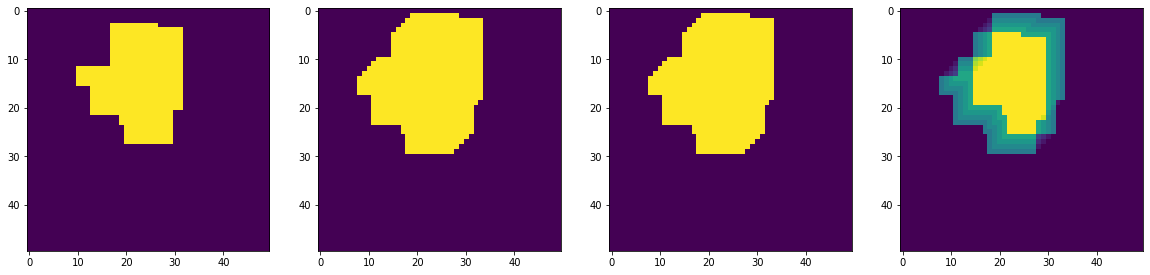

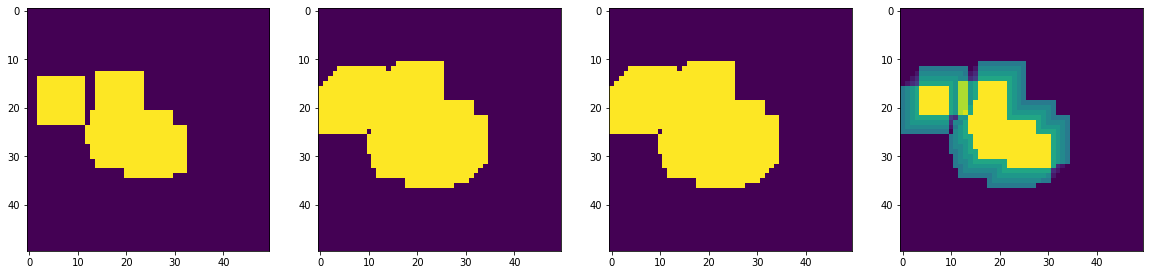

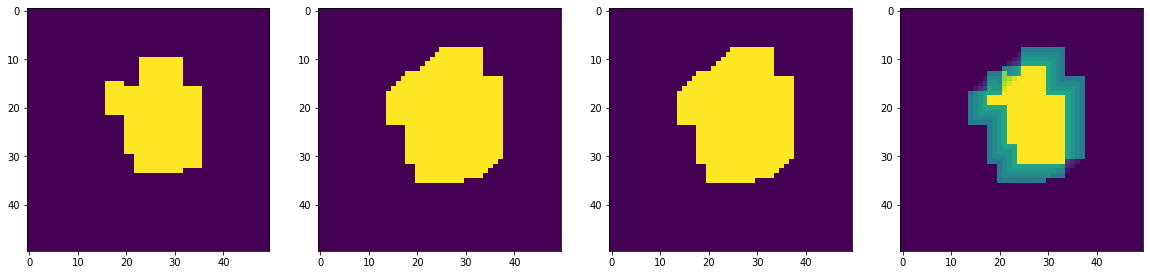

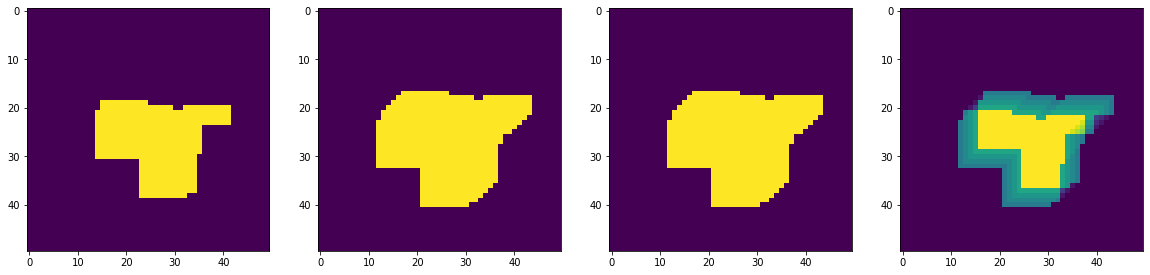

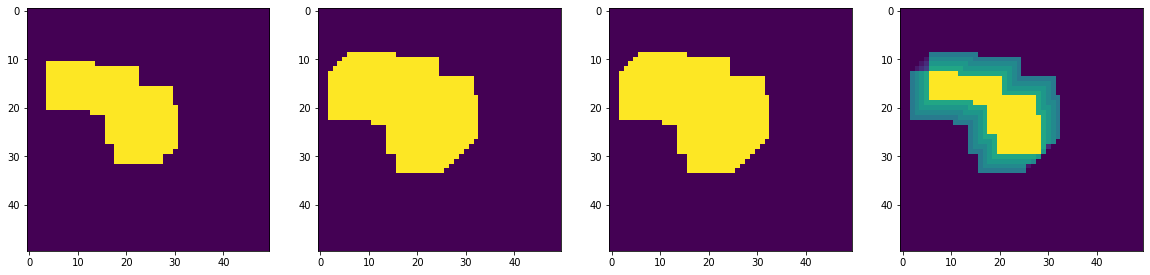

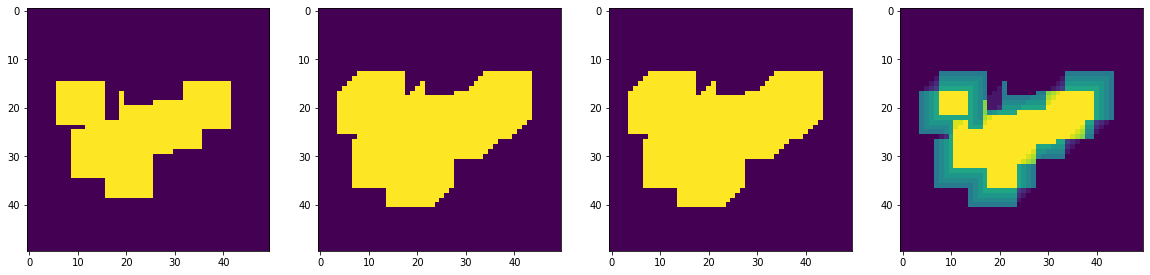

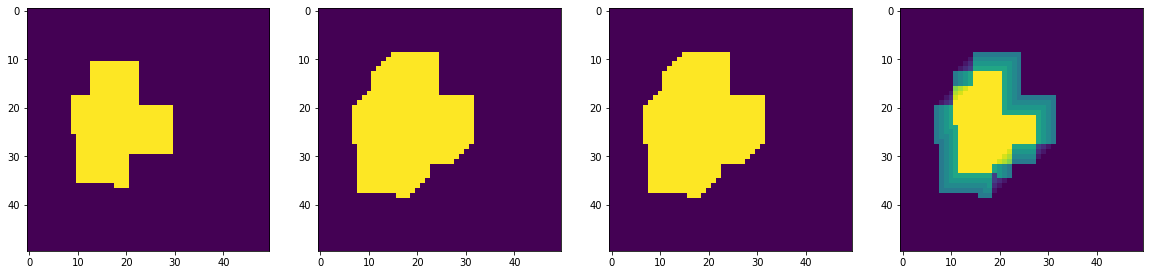

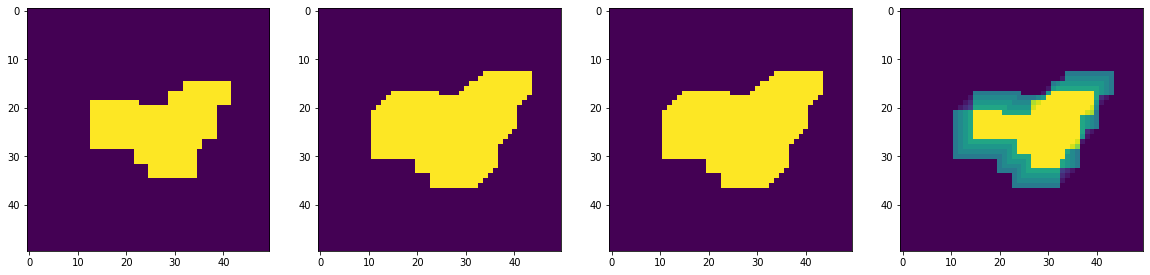

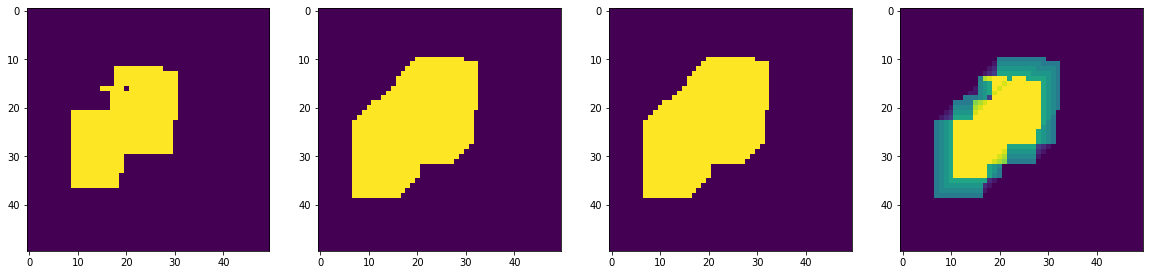

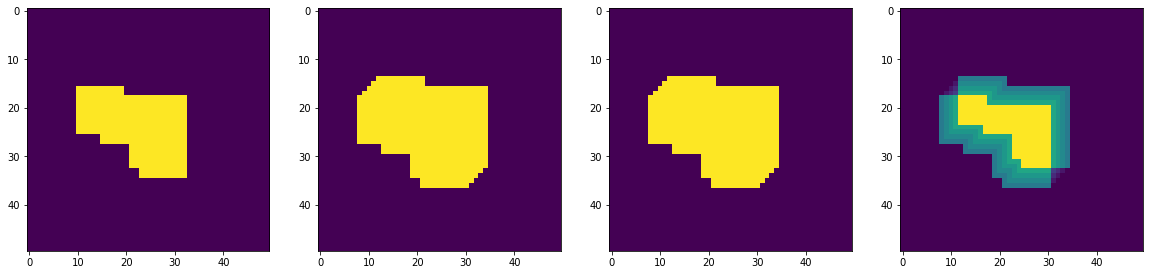

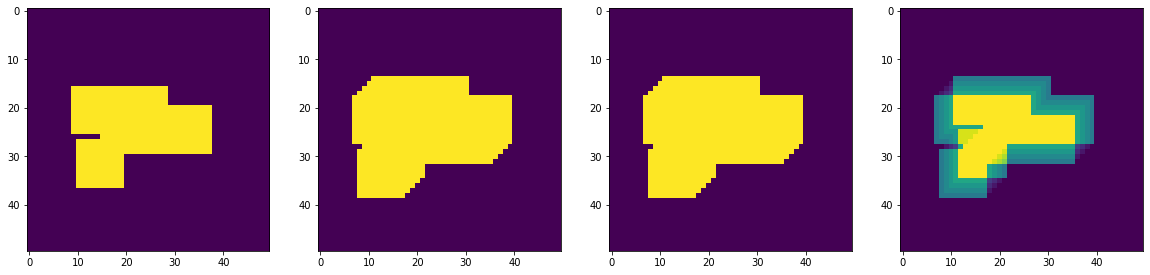

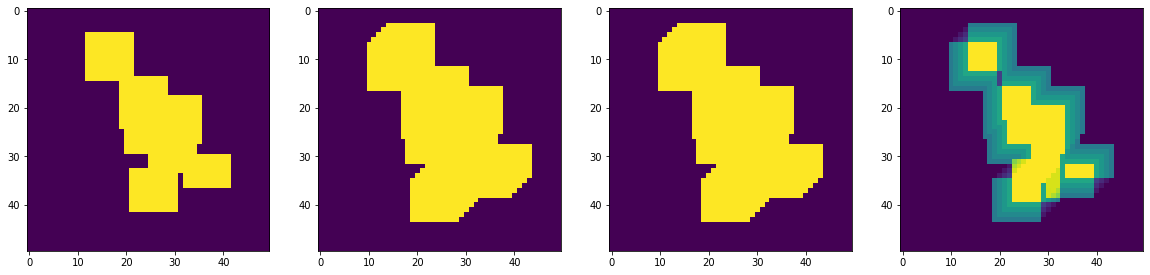

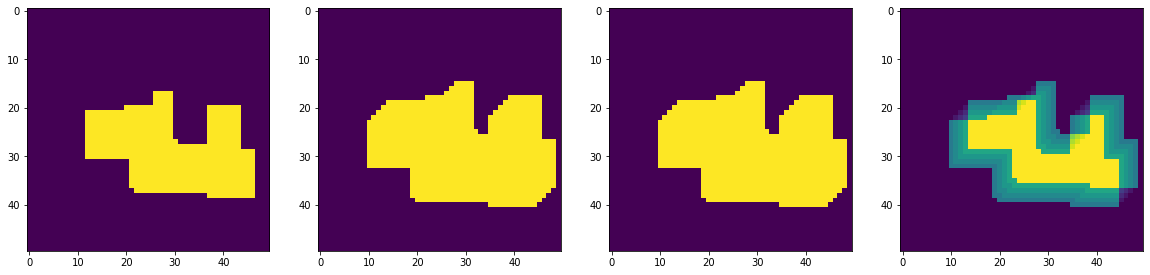

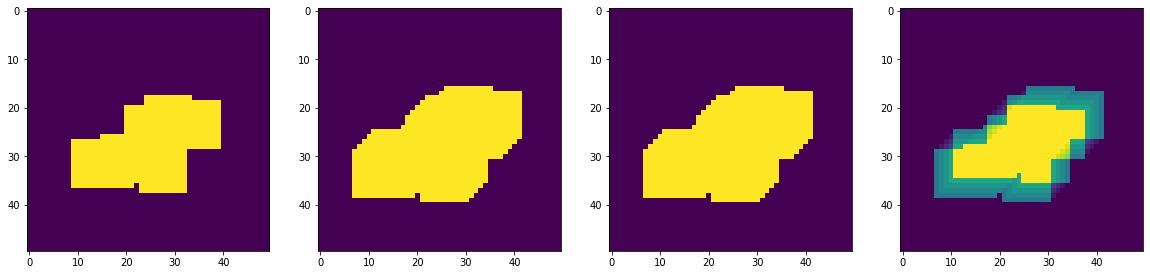

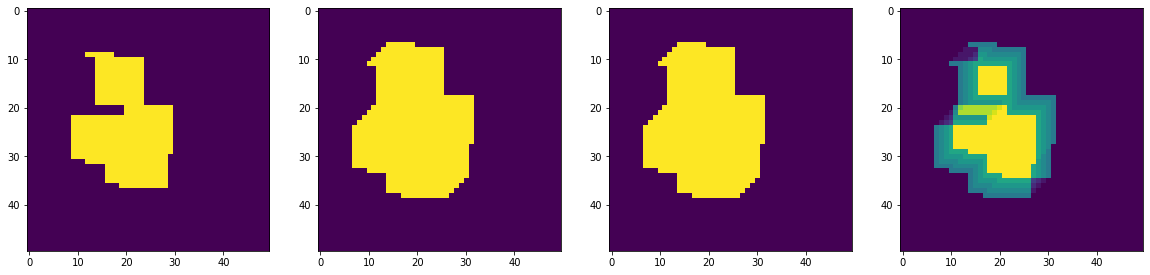

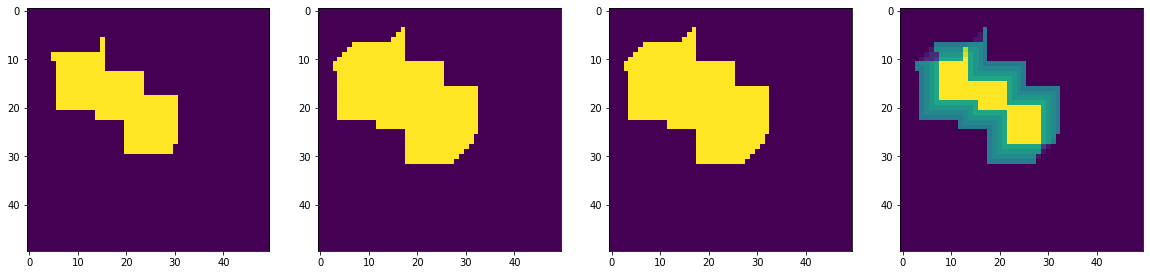

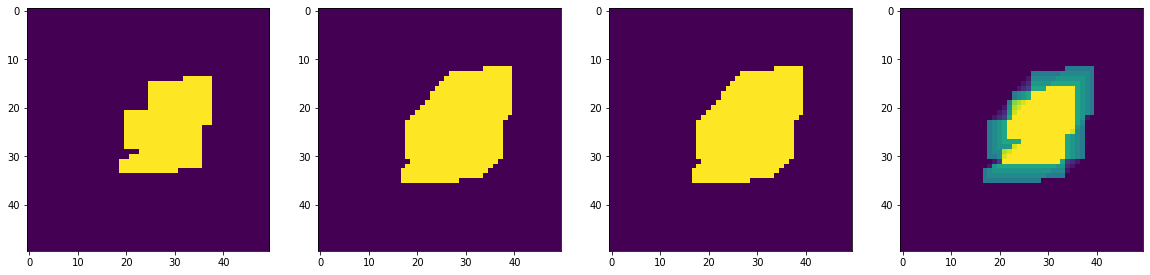

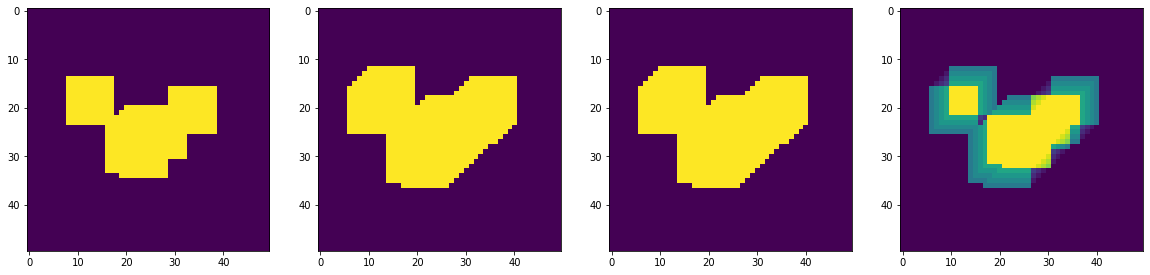

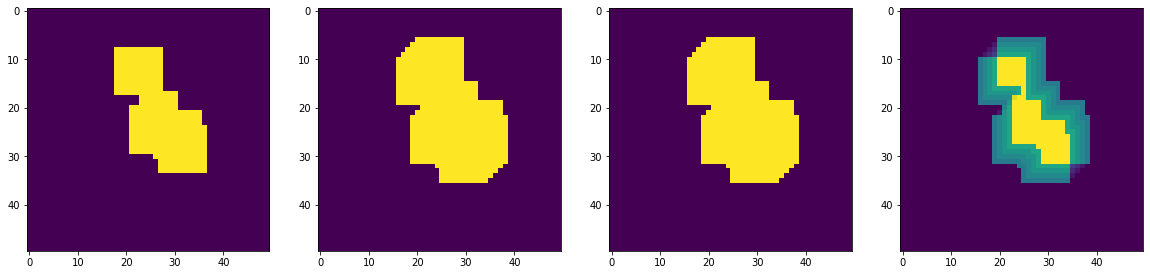

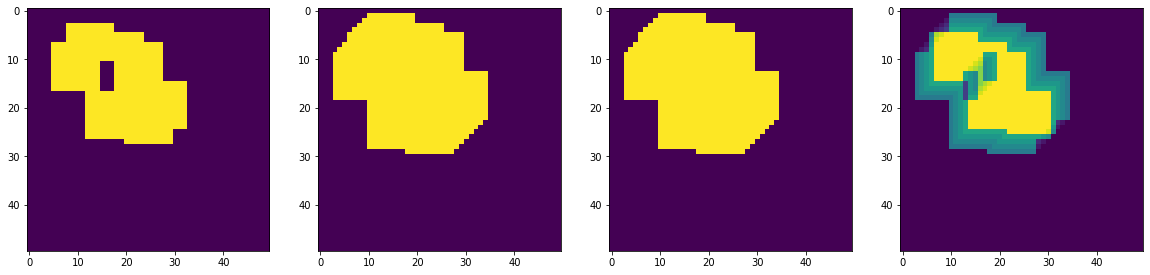

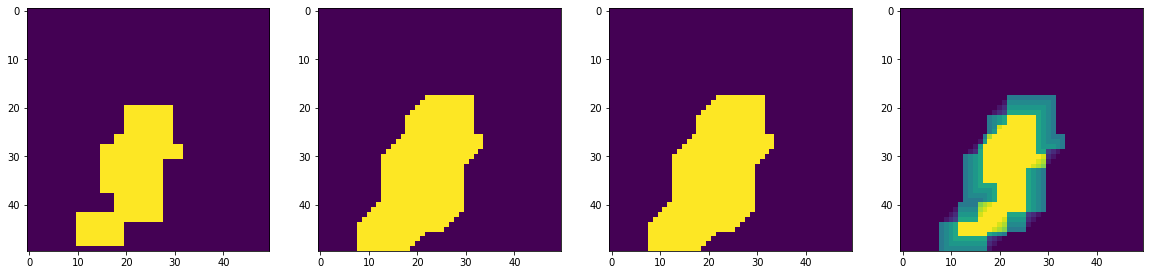

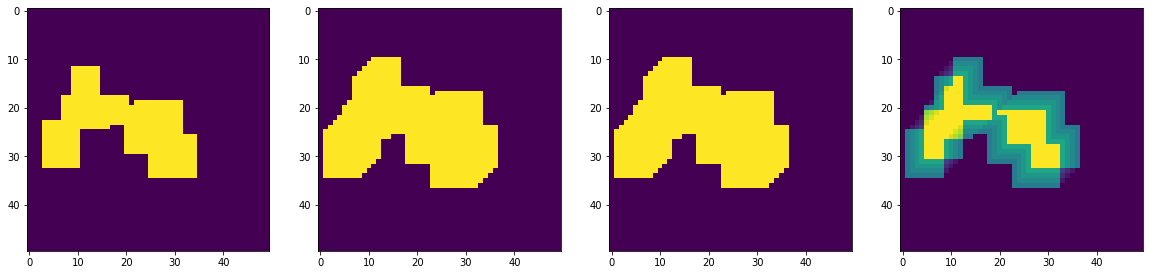

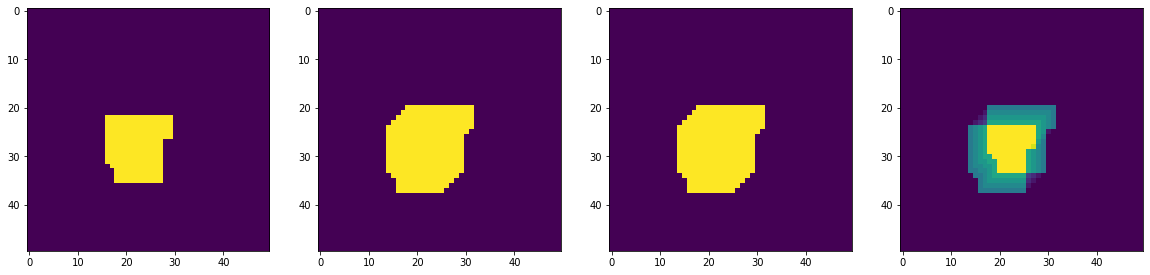

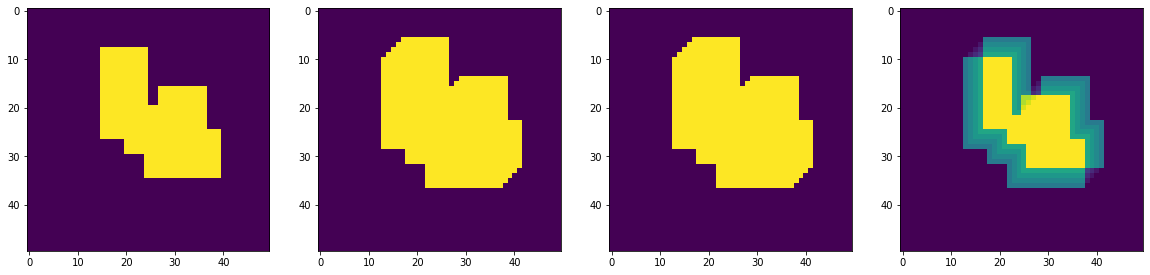

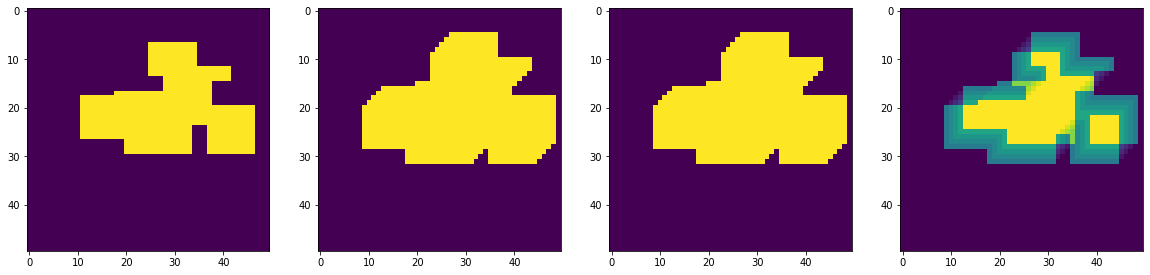

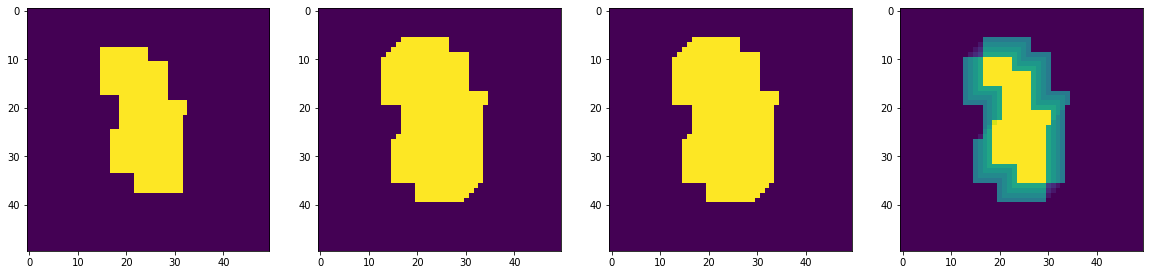

In [113]:
model.to(device)
inputs, targets = next(iter(dataloader))
outputs = model(inputs)
for idx in range(len(inputs)):
    plot_horizontal([tensor[idx].squeeze().cpu().detach() for tensor in [
        inputs, targets, outputs > 0.05, outputs]])

In [110]:
print(model.model.conv.weight)
print(model.model._normalized_weight)
print(model.model.P_)

Parameter containing:
tensor([[[[-0.1435, -0.1434, -0.1436, -0.1433,  0.9307],
          [-0.1434, -0.1434, -0.1434,  0.0202, -0.1433],
          [-0.1435, -0.1433,  0.0130, -0.1434, -0.1434],
          [-0.1433,  0.0191, -0.1431, -0.1431, -0.1435],
          [ 0.9319, -0.1432, -0.1434, -0.1435, -0.1435]]]], device='cuda:0',
       requires_grad=True)
tensor([[[[1.4809e-05, 5.0633e-05, 0.0000e+00, 8.8175e-05, 4.0749e-01],
          [7.8492e-05, 6.5323e-05, 7.1099e-05, 6.2133e-02, 9.0181e-05],
          [3.1579e-05, 8.9384e-05, 5.9403e-02, 5.0689e-05, 6.7584e-05],
          [8.9418e-05, 6.1683e-02, 1.8620e-04, 1.8275e-04, 8.5349e-06],
          [4.0793e-01, 1.2621e-04, 4.5783e-05, 1.2316e-05, 1.6386e-05]]]],
       device='cuda:0', grad_fn=<DivBackward0>)
Parameter containing:
tensor([1.], device='cuda:0', requires_grad=True)


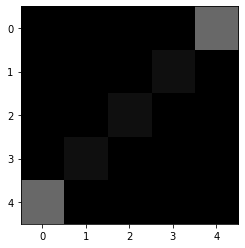

In [109]:
# plt.imshow(torch.sigmoid(model.model.conv.weight).cpu().detach()[0, 0], cmap='gray',
#           vmin=0, vmax=1)
plt.imshow(model.model._normalized_weight.cpu().detach()[0, 0], cmap='gray',
          vmin=0, vmax=1)

## Erosion

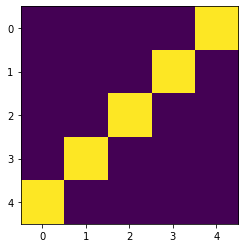

In [5]:
selem = np.zeros((5, 5))
selem[np.arange(5), 5 - np.arange(1, 6)] = 1
plt.imshow(selem)

dataloader = mrda.get_loader(
    batch_size=32, 
    n_inputs=3_000_000, 
    size=(50, 50), 
    n_rectangles=8,
    device=device, 
    max_shape=(10, 10), 
    selem=selem,
    morp_operation="erosion",
)

In [10]:
reload_modules()
loss = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam

model = ldill.LightningDilationLayer(
    model_args={
        "in_channels": 1, "out_channels": 1, "kernel_size": (5, 5), "threshold_mode": "sigmoid"
    },
    learning_rate=1e-4,
    loss=loss,
    optimizer=optimizer,
    output_dir="deep_morpho/results",
)
model.to(device)

logger = TensorBoardLogger("deep_morpho/results", name='Erosion')
print(logger.log_dir)

logger.experiment.add_graph(model, torch.ones(1, 1, 50, 50).to(device))

trainer = Trainer(
    max_epochs=1,
    gpus=1 if torch.cuda.is_available() else 0,
    logger=logger,
    progress_bar_refresh_rate=10,
    callbacks=[obs.PlotParameters()]
)


trainer.fit(model, dataloader)


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
/hdd/python_venvs/torchenv/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: you defined a validation_step but have no val_dataloader. Skipping val loop
  warnings.warn(*args, **kwargs)
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params
--------------------------------------------
0 | model | DilationLayer     | 27    
1 | loss  | BCEWithLogitsLoss | 0     
--------------------------------------------
27        Trainable params
0         Non-trainable params
27        Total params
0.000     Total estimated model params size (MB)


deep_morpho/results/Erosion/version_4


Validation sanity check: 0it [00:00, ?it/s]

/hdd/python_venvs/torchenv/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 24 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Training: 0it [00:00, ?it/s]

In [16]:
model = ldill.LightningDilationLayer.load_from_checkpoint(join("deep_morpho/results/Erosion/version_3/checkpoints/epoch=0-step=93749.ckpt"))

torch.Size([32, 1, 50, 50])

<ipython-input-3-dde04c21c33b>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(5*n_figs, 5))


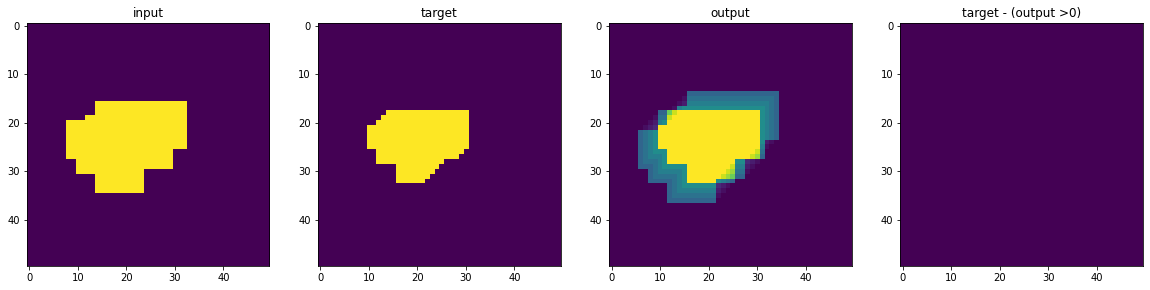

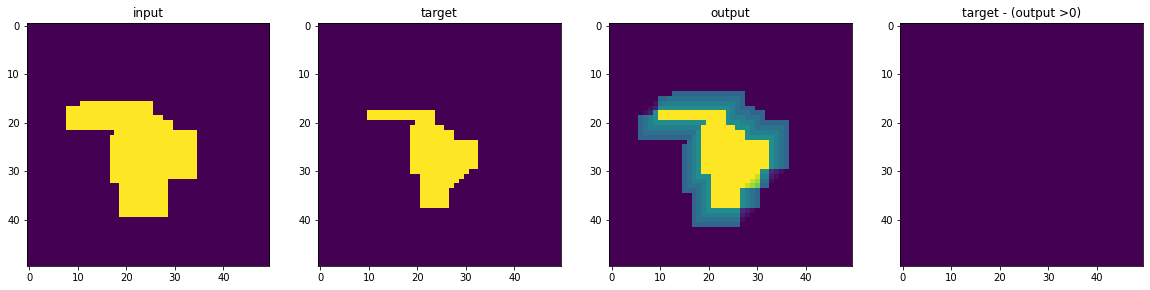

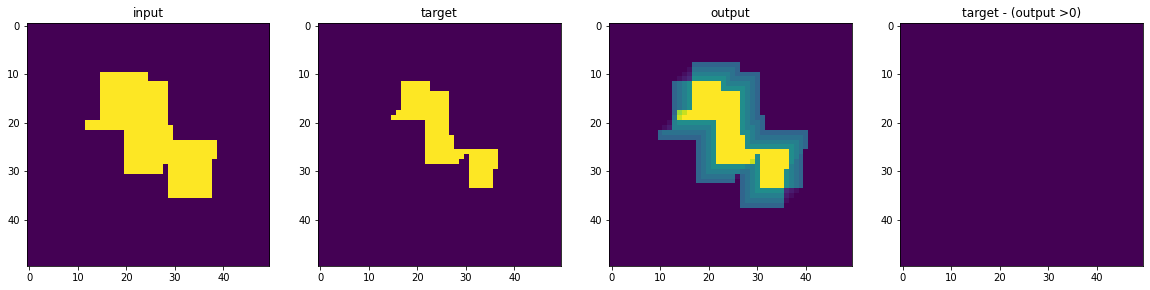

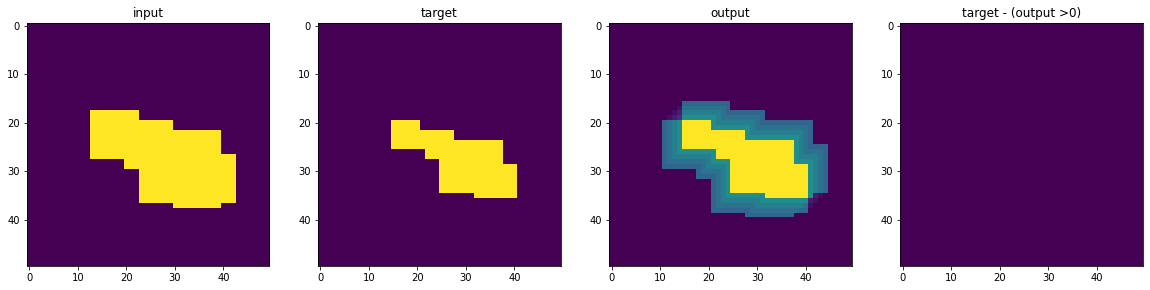

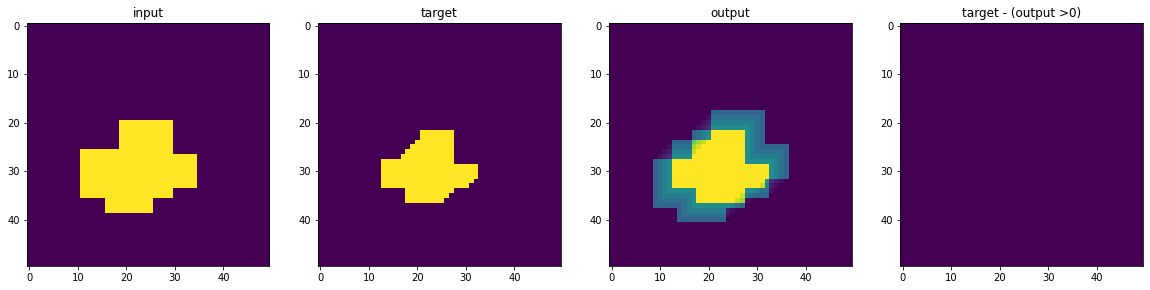

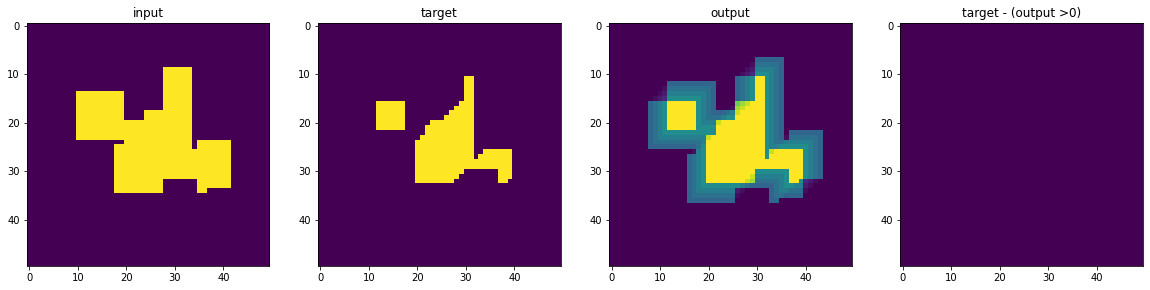

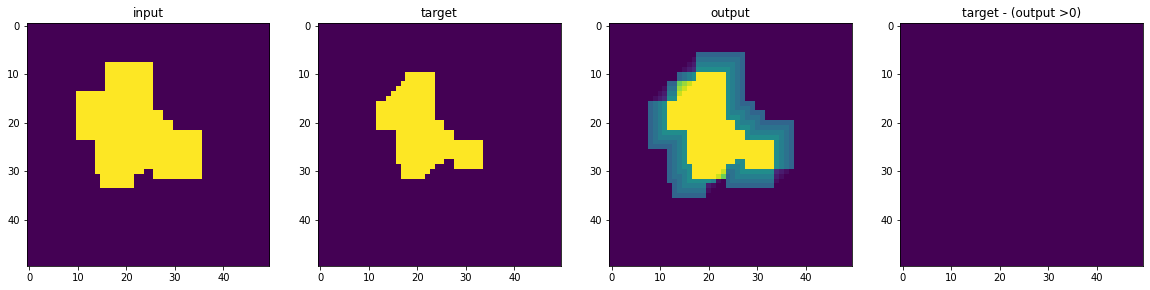

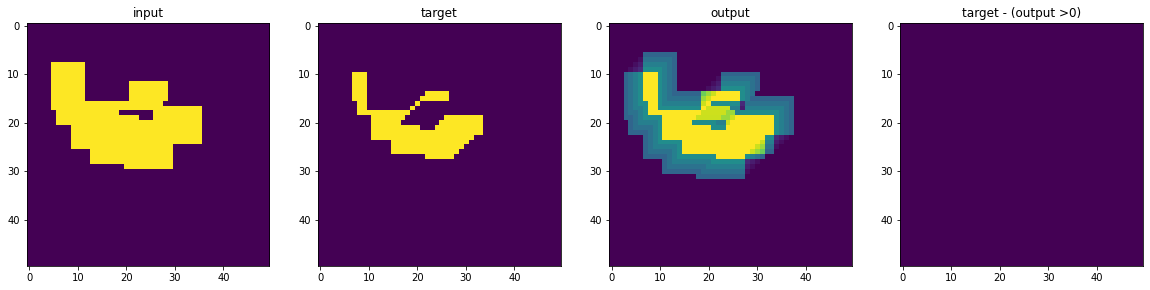

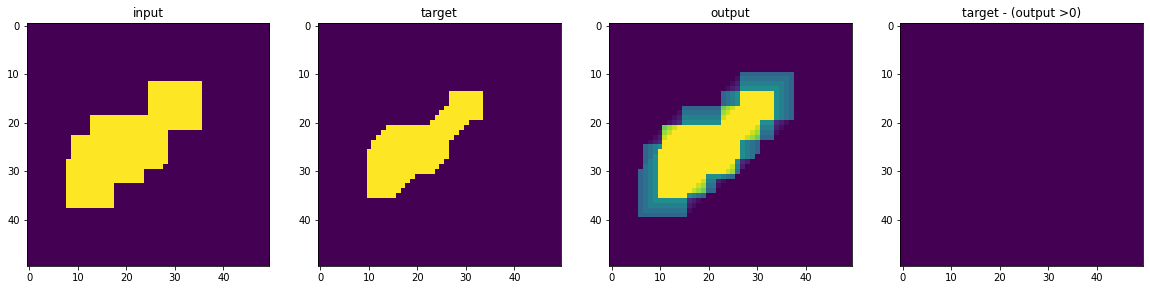

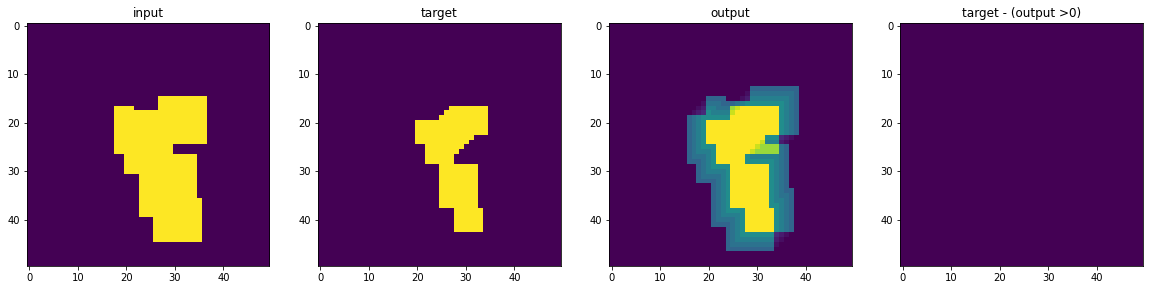

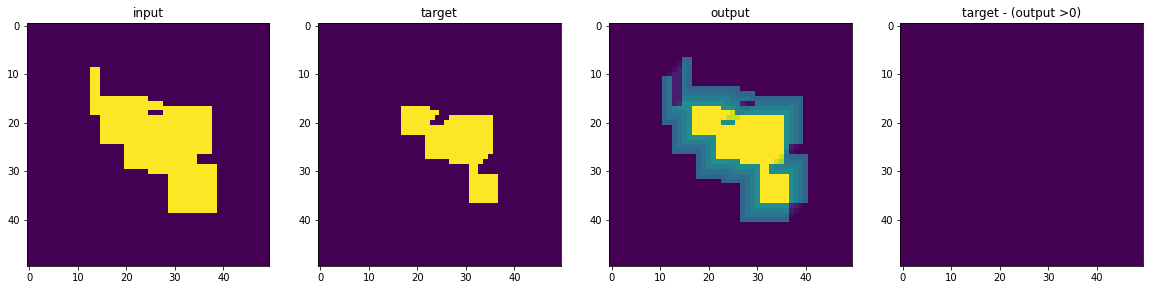

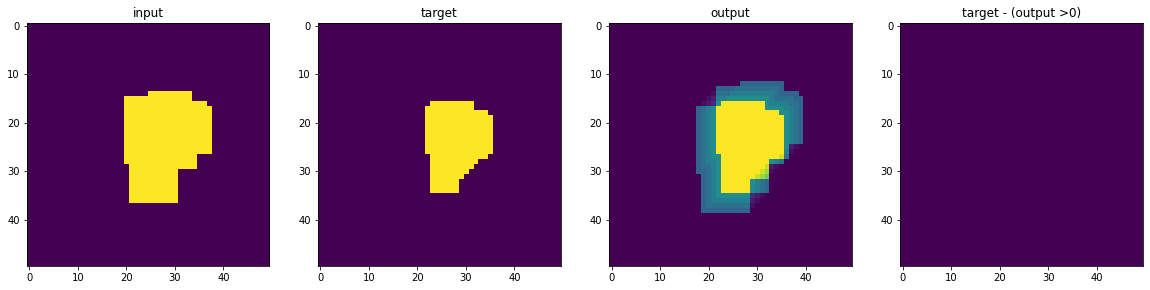

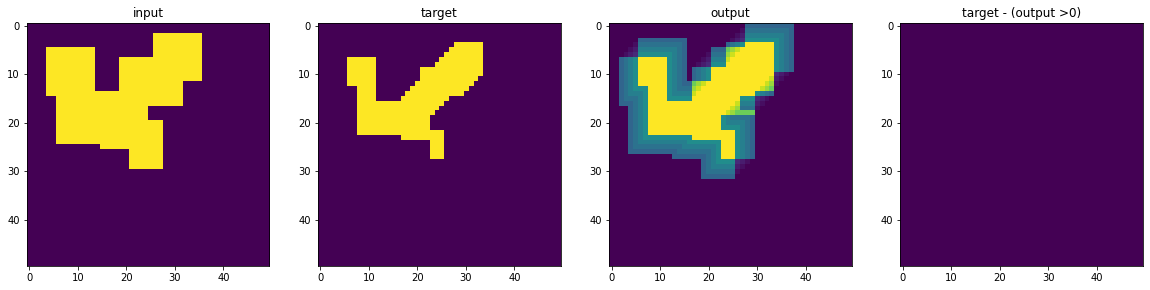

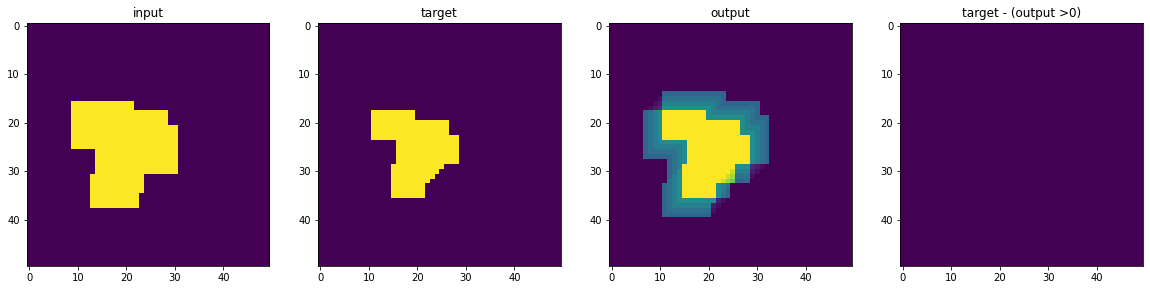

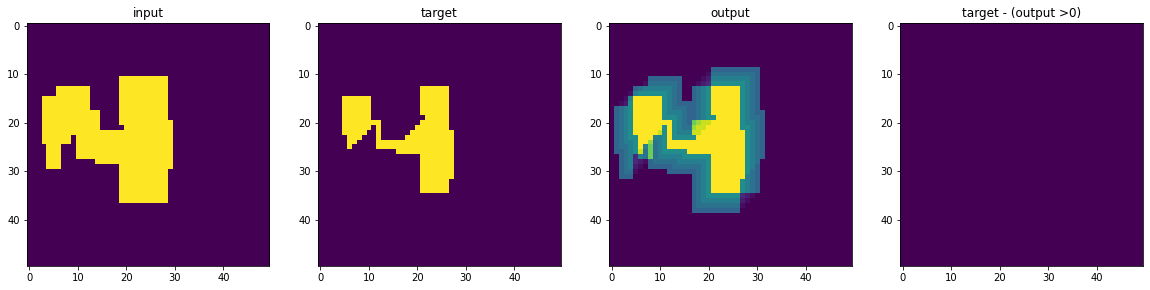

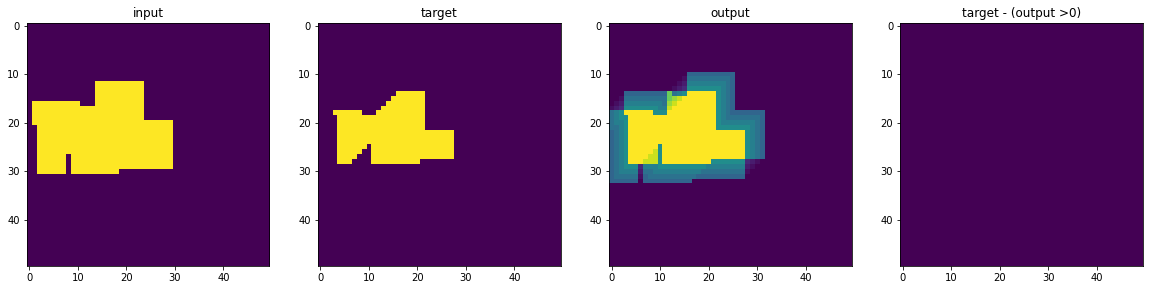

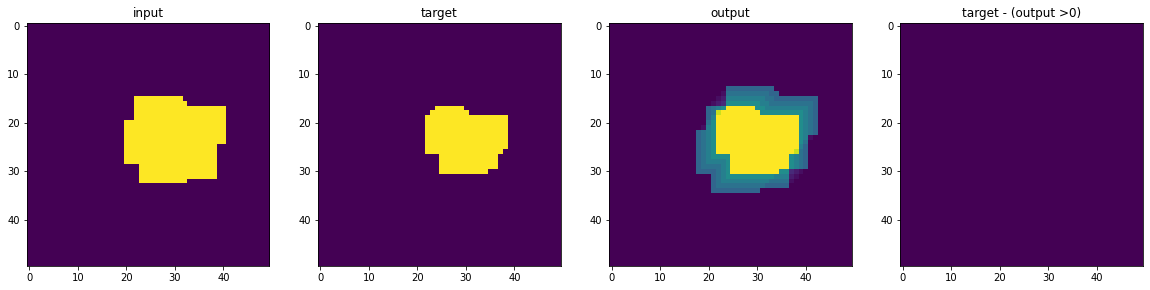

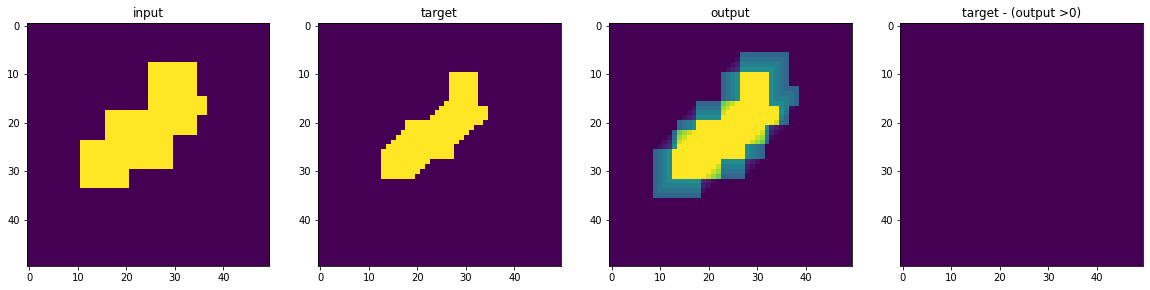

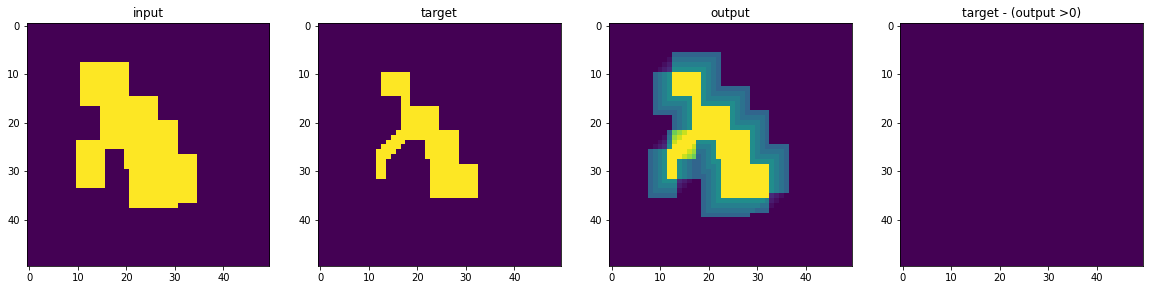

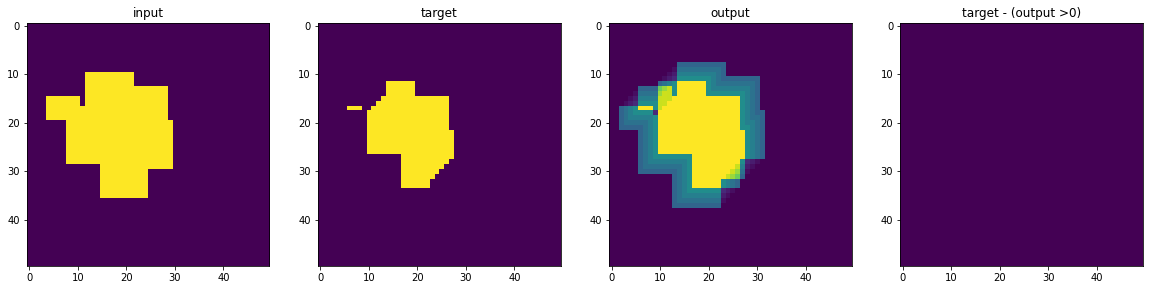

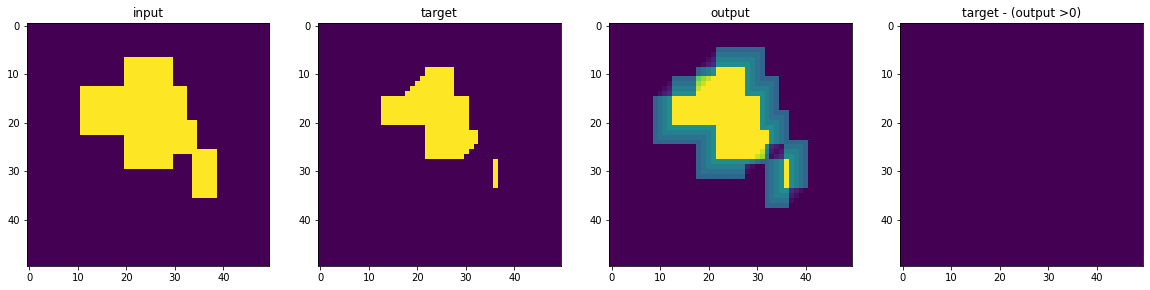

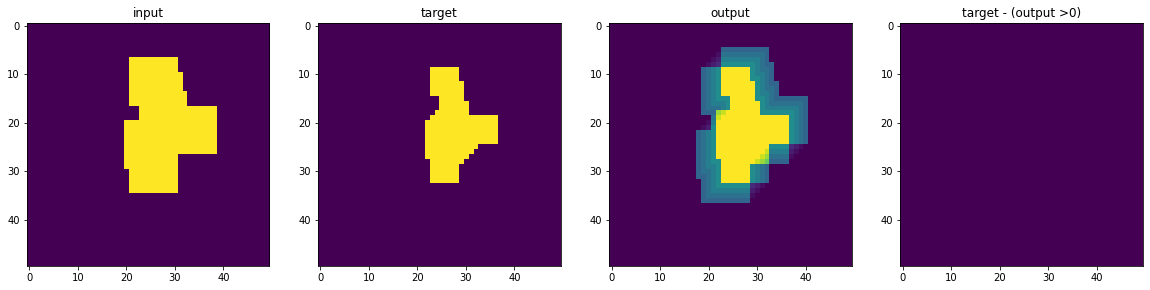

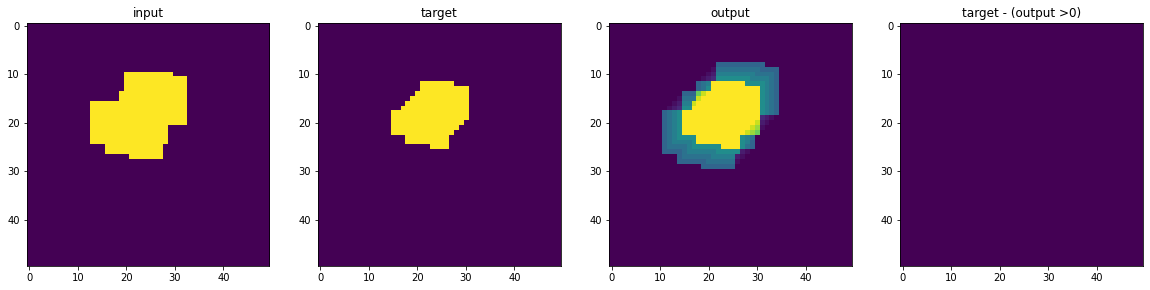

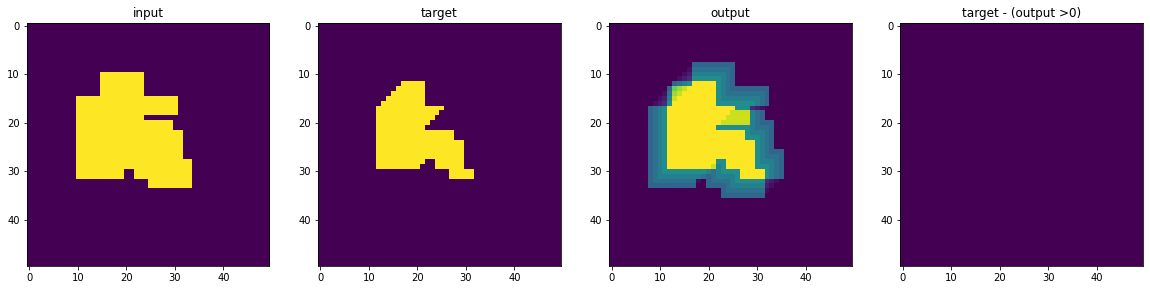

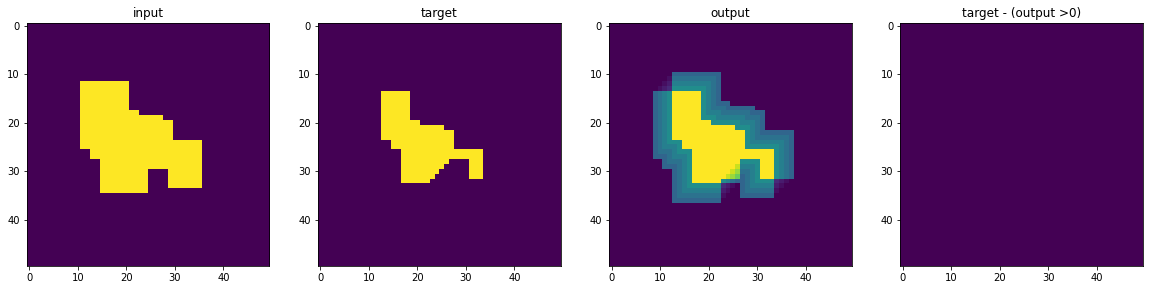

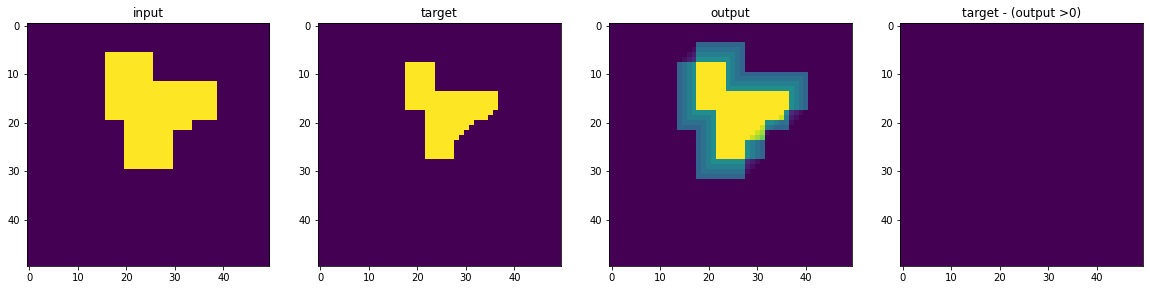

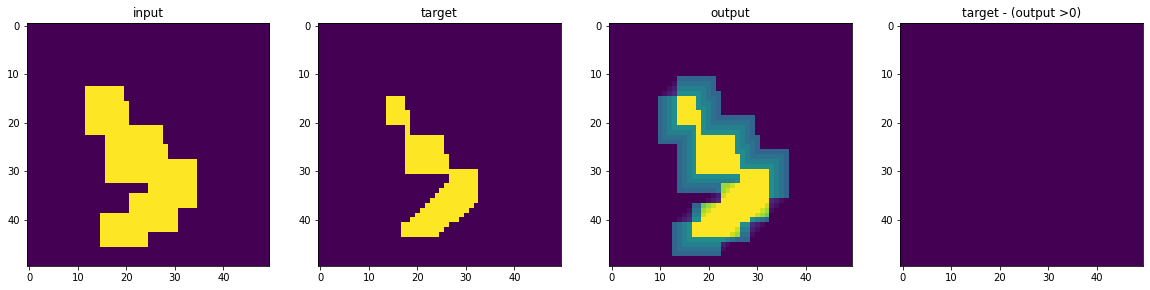

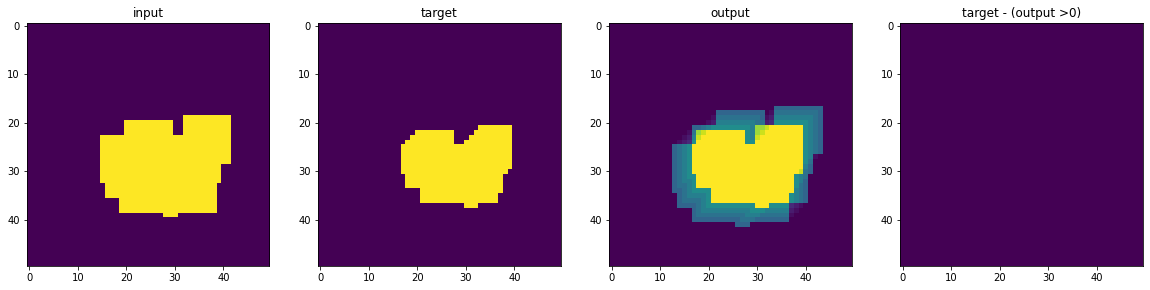

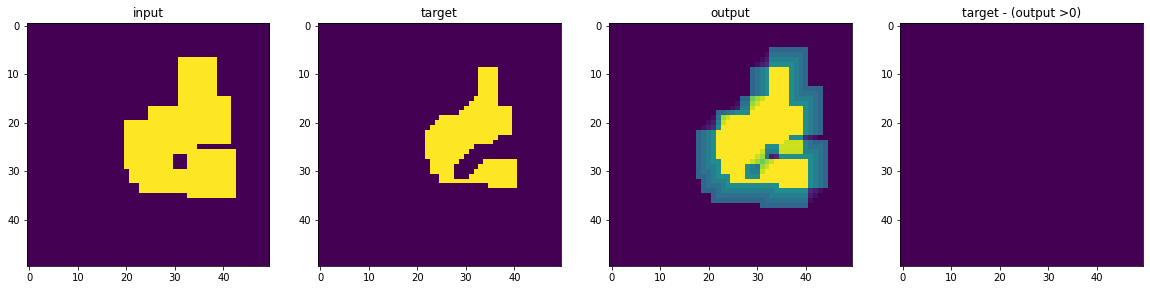

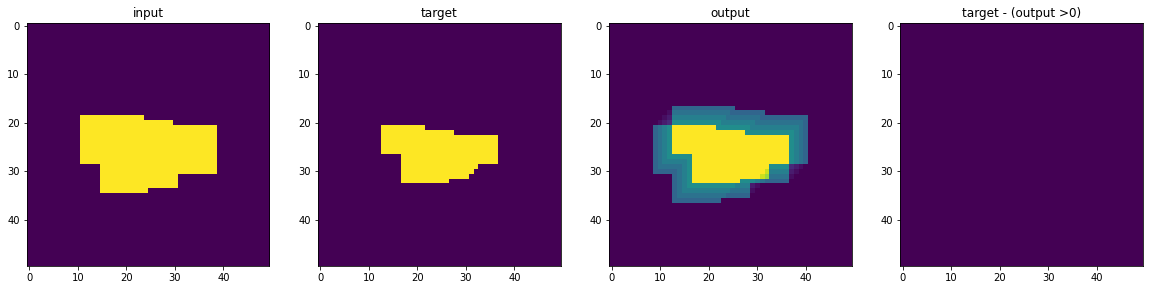

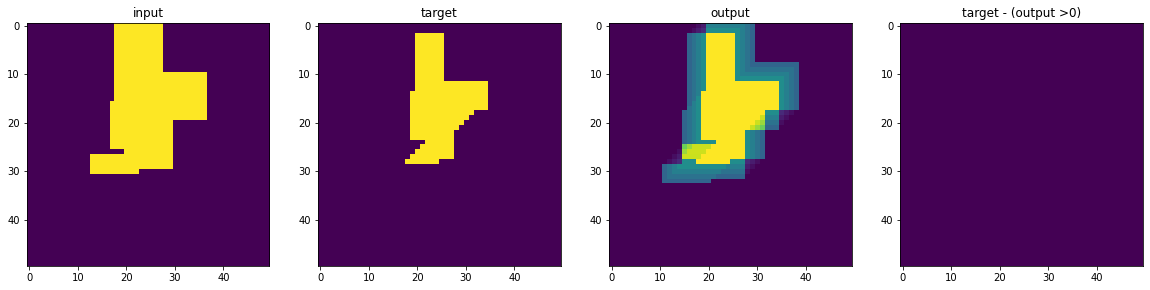

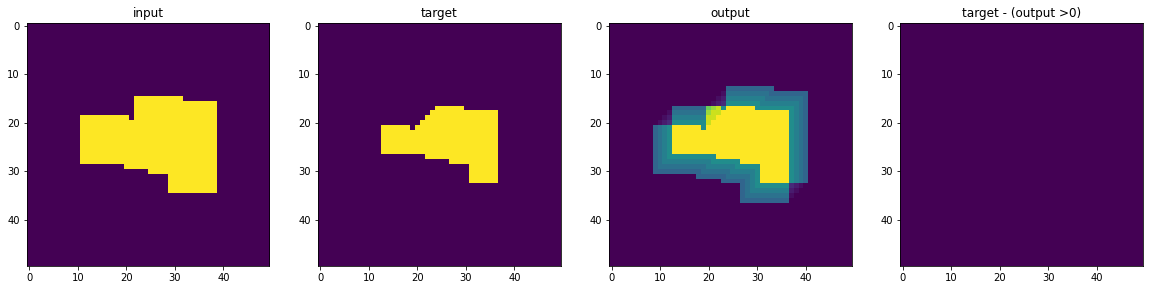

In [11]:
# thresh = torch.sigmoid(outputs).max()/2
thresh = 0

model.to(device)
inputs, targets = next(iter(dataloader))
outputs = model(inputs)[:5]
for idx in range(len(outputs)):
    plot_horizontal([tensor[idx].squeeze().cpu().detach() for tensor in [
        inputs, targets, torch.sigmoid(outputs), 
        (torch.sigmoid(outputs).squeeze() > thresh)]],
                   title=["input", "target", "output", f"target - (output >{thresh})"])

In [14]:
outputs[0].unique()
print(torch.sigmoid(outputs[0]).unique())

tensor([0.0712, 0.0712, 0.0712, 0.0749, 0.0749, 0.0751, 0.0751, 0.0751, 0.0789,
        0.0789, 0.0789, 0.0832, 0.1041, 0.1041, 0.1041, 0.1041, 0.1041, 0.1041,
        0.1041, 0.1041, 0.1041, 0.1096, 0.1096, 0.1096, 0.1096, 0.1096, 0.1096,
        0.1096, 0.1096, 0.1096, 0.1149, 0.1149, 0.1149, 0.1149, 0.1149, 0.1149,
        0.1150, 0.1150, 0.1150, 0.1150, 0.1209, 0.1209, 0.1209, 0.1209, 0.1209,
        0.1209, 0.1209, 0.1498, 0.1498, 0.1572, 0.1573, 0.1645, 0.1645, 0.1645,
        0.1649, 0.1649, 0.1725, 0.1725, 0.1725, 0.1725], device='cuda:0',
       grad_fn=<Unique2Backward>)


In [16]:
print(model.model._normalized_weight)

tensor([[[[2.3010e-08, 3.4614e-08, 6.1712e-08, 2.9379e-07, 4.1607e-01],
          [3.2933e-08, 6.6937e-08, 1.5739e-07, 5.6941e-02, 2.9607e-07],
          [6.3411e-08, 1.5617e-07, 5.3850e-02, 1.6665e-07, 6.4267e-08],
          [2.8954e-07, 5.7078e-02, 1.5920e-07, 6.4007e-08, 3.5172e-08],
          [4.1605e-01, 3.1508e-07, 6.9191e-08, 3.3984e-08, 2.0911e-08]]]],
       device='cuda:0', grad_fn=<DivBackward0>)


In [15]:
model.model.threshold_fn

<function deep_morpho.models.dilation_layer.DilationLayer.__init__.<locals>.<lambda>(x)>

In [53]:
model.model.weight.cpu().detach().numpy()[0, 0, np.arange(5), 4 - np.arange(5)].sum()

2.7563252